In [58]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import numpy as np
from perlin_noise import PerlinNoise
from Quadtree import QTree
np.random.seed(1)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300

# Dividing ice region with different ice type

We propose to divide to divied a certain region between First-Year Ice, Multi-Year and water. In order to simulate those region we use a Perlin noise.

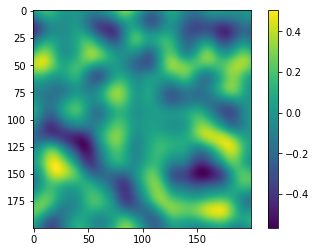

In [59]:
#Define the geometry for ice types

px_macro=200 #Number of pixels that defines the ice region
noise = PerlinNoise(octaves=6, seed=1)
xpix, ypix = px_macro, px_macro
pic_macro = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
pic_macro=np.array(pic_macro)

plt.imshow(pic_macro)
plt.colorbar()
plt.show()

To define the ice types we devide the Perlin noise between high values (MYI), low values (water) and intermediate values (FYI).

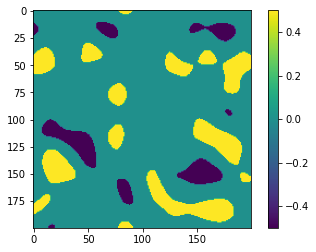

In [60]:
#Define threshold to define block types (high values=MYI, low values=water, intermediate=FYI)
pic_macro[pic_macro<-0.3]=-0.5
pic_macro[pic_macro>0.2]=0.5
pic_macro[(pic_macro < 0.5) * (pic_macro > -0.5)]=0
plt.imshow(pic_macro)
plt.colorbar()
plt.show()

## Example with real segmented SAR image

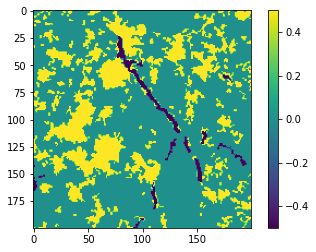

In [61]:
pic_macro = np.loadtxt('mask.txt',delimiter=',')
pic_macro=pic_macro[:200,:200]
plt.imshow(pic_macro)
plt.colorbar()
plt.show()

## Smoothed segmented SAR image

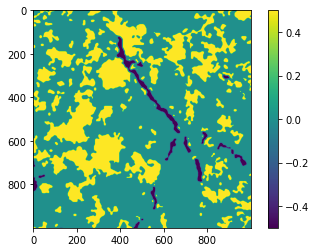

In [62]:
pic_macro = np.loadtxt('mask_refined.txt',delimiter=',')
pic_macro=pic_macro[:1000,:1000]
plt.imshow(pic_macro)
plt.colorbar()
plt.show()

px_macro=1000
xpix, ypix = px_macro, px_macro

# Quadtree mesh

Building a quadtree allows to work with region composed by cubes of different size. Each cube can be defined as an individual ice block where we will apply the buoyancy model. This is useful to regroup region that shares same characteristics (same density) because we don't want to have all independent or fully dependent pixels for the buoyancy model. Working with a segmentation algorithm and pixel values might be an other solution.

In [63]:
#Build Quadtree mesh

pic_macro=pic_macro-np.min(pic_macro)
pic_macro=255*(pic_macro/np.max(pic_macro))

pic_macro = pic_macro.astype(np.uint8)

img2=np.zeros((xpix,ypix,3))
img2[:,:,0]=pic_macro
img2[:,:,1]=pic_macro
img2[:,:,2]=pic_macro
img2=img2.astype(np.uint8)

qtTemp = QTree(1, 0.1, img2)  #contrast threshold, min cell size, img

qtTemp.subdivide() # recursively generates quad tree
#qtTemp.graph_tree()

The output of the quadtree segmentation is the list of rectangles with origin coordinate, size and type (fyi, myi or water).

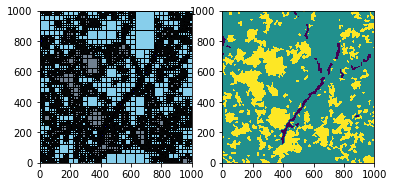

In [64]:
qt_types=qtTemp.get_rectangles()

fig, ax = plt.subplots(1,2)

for k in range(len(qt_types)):
    if qt_types[k,-1]==1:
        type_color='skyblue'
    elif qt_types[k,-1]==2:
        type_color='slategray'
    else:
        type_color='navy'
    ax[0].add_patch(patches.Rectangle((qt_types[k,1],qt_types[k,0]), qt_types[k,3], qt_types[k,2], edgecolor = 'black',facecolor=type_color))
ax[0].set_xlim(0,xpix)
ax[0].set_ylim(0,ypix)
ax[1].pcolormesh(pic_macro)
ax[0].set_aspect('equal','box')
ax[1].set_aspect('equal','box')
plt.show()

# Application roughness models

In order to improve the geometry of the ice region we add pertubation on the bottom and top surface of the ice. Pertubations for a given block will be random but will follow same distribution. To describe the geometry more precisely we divide the orignal pixel size by some factor.

In [65]:
px_micro=1 #Number of pxl micro in 1 macro pxl = resolution

xx_micro, yy_micro = np.mgrid[0:px_micro*px_macro, 0:px_micro*px_macro]
xx_micro=xx_micro/px_micro
yy_micro=yy_micro/px_micro

Ideally we would like a 1 m resolution

Then we define: top ice, bottom ice pertubations for both MYI and FYI. Here again we choose Perlin noises to model those perturbations.

## Top FYI perturbation

We choose something smooth with a large correlation length

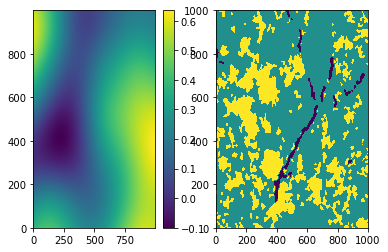

In [66]:
noise_top_fyi = PerlinNoise(octaves=1.5)

xpix_meso, ypix_meso = px_micro*px_macro, px_micro*px_macro
pic_top_fyi = [[noise_top_fyi([i/xpix_meso, j/ypix_meso]) for j in range(xpix_meso)] for i in range(ypix_meso)]
pic_top_fyi=np.array(pic_top_fyi)
pic_top_fyi=pic_top_fyi
pic_top_fyi=pic_top_fyi-np.min(pic_top_fyi)-0.1
fig,ax=plt.subplots(1,2)
im1=ax[0].pcolormesh(xx_micro,yy_micro,pic_top_fyi)
plt.colorbar(im1,ax=ax[0])
ax[1].pcolor(pic_macro)
plt.show()

## Bottom FYI pertubation

For the bottom part we also choose something smooth

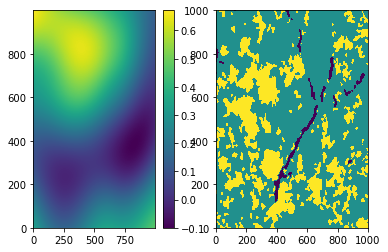

In [67]:
noise_bot_fyi = PerlinNoise(octaves=1.5)

pic_bot_fyi=[[noise_bot_fyi([i/xpix_meso, j/ypix_meso]) for j in range(xpix_meso)] for i in range(ypix_meso)]
pic_bot_fyi=np.array(pic_bot_fyi)
pic_bot_fyi=pic_bot_fyi
pic_bot_fyi=pic_bot_fyi-np.min(pic_bot_fyi)-0.1

fig,ax=plt.subplots(1,2)
im1=ax[0].pcolormesh(xx_micro,yy_micro,pic_bot_fyi)
plt.colorbar(im1,ax=ax[0])
ax[1].pcolor(pic_macro)
plt.show()

## Top MYI pertubation

Here we choose a very small correlation noise to represent very rough top ice. In order to save time we simulate the noise only on some division of the domain and we fill the rest with some random rotation of the simulated part.

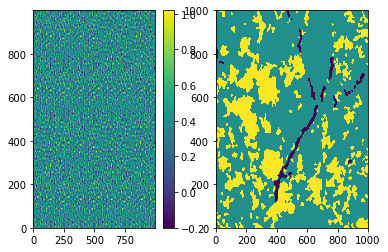

In [68]:
noise_top_myi = PerlinNoise(octaves=24)

px_sub=4
xpix_meso, ypix_meso = int(px_micro*px_macro/px_sub), int(px_micro*px_macro/px_sub)
pic_top_myi_patch = [[noise_top_myi([i/xpix_meso, j/ypix_meso]) for j in range(xpix_meso)] for i in range(ypix_meso)]
pic_top_myi_patch=np.array(pic_top_myi_patch)
pic_top_myi_patch=pic_top_myi_patch-np.min(pic_top_myi_patch)-0.2

pic_top_myi=np.zeros((px_macro*px_micro,px_macro*px_micro))

for i in range(px_sub):
    for j in range(px_sub):
        r=np.random.rand(1)
        if r <0.5:
            pic_top_myi[xpix_meso*i:xpix_meso*(i+1),ypix_meso*j:ypix_meso*(j+1)]=pic_top_myi_patch
        else:
            pic_top_myi[xpix_meso*i:xpix_meso*(i+1),ypix_meso*j:ypix_meso*(j+1)]=pic_top_myi_patch.T

fig,ax=plt.subplots(1,2)
im1=ax[0].pcolormesh(xx_micro,yy_micro,pic_top_myi)
plt.colorbar(im1,ax=ax[0])
ax[1].pcolor(pic_macro)
plt.show()

TO DO: Also add a smooth variation to the roughnees pertubation (like top ice perturbation)

## Bottom MYI pertubation

Here we choose something smoother than the top MYI but still with a smaller scale than top or bottom FYI.

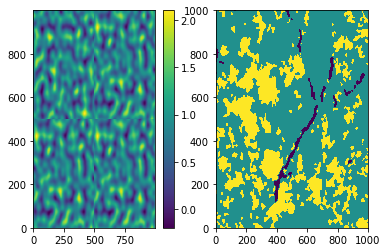

In [69]:
noise_bot_myi = PerlinNoise(octaves=10)

px_sub=2

xpix_meso, ypix_meso = int(px_macro*px_micro/px_sub), int(px_macro*px_micro/px_sub)
pic_bot_myi_patch = [[noise_bot_myi([i/xpix_meso, j/ypix_meso]) for j in range(xpix_meso)] for i in range(ypix_meso)]
pic_bot_myi_patch=2*np.array(pic_bot_myi_patch)

pic_bot_myi_patch=pic_bot_myi_patch-np.min(pic_bot_myi_patch)-0.2
pic_bot_myi_patch=pic_bot_myi_patch

pic_bot_myi=np.zeros((px_macro*px_micro,px_macro*px_micro))

for i in range(px_sub):
    for j in range(px_sub):
        r=np.random.rand(1)
        if r <0.5:
            pic_bot_myi[xpix_meso*i:xpix_meso*(i+1),ypix_meso*j:ypix_meso*(j+1)]=pic_bot_myi_patch
        else:
            pic_bot_myi[xpix_meso*i:xpix_meso*(i+1),ypix_meso*j:ypix_meso*(j+1)]=pic_bot_myi_patch.T

fig,ax=plt.subplots(1,2)
im1=ax[0].pcolormesh(xx_micro,yy_micro,pic_bot_myi)
plt.colorbar(im1,ax=ax[0])
ax[1].pcolor(pic_macro)
plt.show()

## Snow accumulation

Snow accumulation is also define with a large scale Perlin noise.

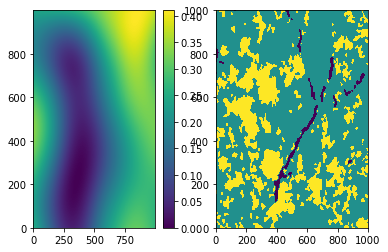

In [70]:
noise_snow = PerlinNoise(octaves=1.5)

xpix_meso=px_micro*px_macro
ypix_meso=px_micro*px_macro

pic_snow=[[noise_snow([i/xpix_meso, j/ypix_meso]) for j in range(xpix_meso)] for i in range(ypix_meso)]
pic_snow=np.array(pic_snow)
pic_snow=pic_snow
pic_snow=pic_snow-np.min(pic_snow)
pic_snow=pic_snow/np.max(pic_snow)
pic_snow=pic_snow*0.41

fig,ax=plt.subplots(1,2)
im1=ax[0].pcolormesh(xx_micro,yy_micro,pic_snow)
plt.colorbar(im1,ax=ax[0])
ax[1].pcolor(pic_macro)
plt.show()

# Adding thickness and density to quadtree rectangles

For each rectangles of the quadtree mesh we add a thickness and a density. These quantities are randomly generated following different chracteristic distributions for FYI and MYI.

In [71]:
qt_types_micro=px_micro*qt_types
qt_types_micro=qt_types_micro.astype(int)

pic_micro=np.zeros((px_macro*px_micro,px_micro*px_macro))
pic_thickness=np.zeros(pic_micro.shape)
pic_sm=np.zeros(pic_micro.shape)
pic_rho_i=np.zeros(pic_micro.shape)

pic_top=np.zeros(pic_micro.shape)
pic_bot=np.zeros(pic_micro.shape)

for quad in range(len(qt_types)):
    x0_m=qt_types_micro[quad,0]
    y0_m=qt_types_micro[quad,1]
    lx_m=qt_types_micro[quad,2]
    ly_m=qt_types_micro[quad,3]
    s_m=lx_m*ly_m
    type=qt_types[quad,-1]
    pic_micro[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=type
    pic_sm[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=s_m
    if type==1:
        pic_thickness[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=np.array([0.20+1*np.random.rand(1)])
        pic_top[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_top_fyi[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]
        pic_bot[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_bot_fyi[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]
        pic_rho_i[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=916.7-35.7+2*35.7*np.random.rand(1)
        # Random thickness per ice type
    if type==2:
        pic_thickness[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=np.array([1.5+3*np.random.rand(1)])
        pic_top[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_top_myi[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]
        pic_bot[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_bot_myi[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]
        pic_rho_i[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]= 882-23+46*np.random.rand(1)
        # Random thickness per ice type
pic_sm=pic_sm-np.min(pic_sm)
pic_sm=pic_sm/np.max(pic_sm)
d=0.2
pic_sm=(1-d)*pic_sm+d

# Visualization of simulated quantites

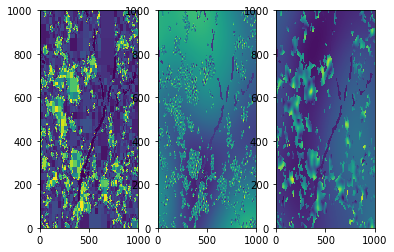

In [72]:
fig,ax=plt.subplots(1,3)
ax[0].pcolormesh(pic_thickness)
ax[1].pcolormesh(pic_top)
ax[2].pcolormesh(pic_bot)

plt.show()

pic_thickness_tot=pic_thickness+pic_top+pic_bot

# Apply buoyancy model 

We apply the hydrostatic buoyancy model to quadtree block with mean thickness per block. We also apply some weighting to the snow accumulation depending of the block type (fyi or myi). Snow density is generated randomly and following a distribution that depends of the underneath ice type.

Remark: here the quadtree blocks are assumed to be independent but stacked together

This will most likely need improvement. 

In [73]:
#Add snow and compute sea_level

pic_sea_level=np.zeros((px_macro*px_micro,px_micro*px_macro))
rho_w=1024
pic_snow_acc=np.zeros((px_macro*px_micro,px_micro*px_macro))

for quad in range(len(qt_types)):
    x0_m=qt_types_micro[quad,0]
    y0_m=qt_types_micro[quad,1]
    lx_m=qt_types_micro[quad,2]
    ly_m=qt_types_micro[quad,3]
    type=qt_types[quad,-1]
    ice_thickness_mean=np.mean(pic_thickness_tot[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m])
    rho_i=np.mean(pic_rho_i[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m])
    if type==1:
        rho_s=324-50+100*np.random.rand(1)
        pic_snow_acc[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_snow[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]/7
    if type==2:
        rho_s= 320-20+40*np.random.rand(1)
        pic_snow_acc[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_snow[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]
    snow_depth_mean=np.mean(pic_snow_acc[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m])
    pic_sea_level[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=(ice_thickness_mean*(rho_w-rho_i)-snow_depth_mean*(rho_s-rho_w))/rho_w
    pic_sea_level[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]=pic_sea_level[x0_m:x0_m+lx_m,y0_m:y0_m+ly_m]-snow_depth_mean

# Computation of useful quanties

Here we compute import quantities to generate final ice region geometry and data:
- Elevation of top ice wrt to sea leval
- Depth of bottom ice wrt to sea level
- Snow accumulation

Each of those three fields are expressed on the subdivised (micro) mesh.

In [74]:
#To keep
top_ice_rel=pic_sea_level+pic_top
bot_ice_rel=-(pic_thickness+pic_bot+pic_sea_level)
pic_snow_acc=pic_snow_acc
# np.savetxt('top_ice_rel.txt',top_ice_rel)
# np.savetxt('bot_ice_rel.txt',bot_ice_rel)
# np.savetxt('snow_acc.txt',pic_snow_acc)

pic_micro_fyi_xx=xx_micro[pic_micro==1]
pic_micro_fyi_yy=yy_micro[pic_micro==1]
pic_micro_myi_xx=xx_micro[pic_micro==2]
pic_micro_myi_yy=yy_micro[pic_micro==2]
pic_snow_xx=np.concatenate((pic_micro_fyi_xx,pic_micro_myi_xx))
pic_snow_yy=np.concatenate((pic_micro_fyi_yy,pic_micro_myi_yy))
rect_water=qt_types[qt_types[:,-1]==0]

# Export to STL files (takes $\approx$ 10 min with a 1000x1000px surface)

We can export the geometry decomposed as fyi, myi, water and snow to STL files that we can read with paraview. A .pvsm with pre-settings of paraview to visualize those files is also available.

In [75]:
from save_stl import save_stl,save_water_stl

pix_size = 10 #pixel size in m
dir='fig_stl'
fname='myi'
save_stl(dir,fname,pic_micro_myi_xx,pic_micro_myi_yy,pix_size,bot_ice_rel,top_ice_rel)
fname='fyi'
save_stl(dir,fname,pic_micro_fyi_xx,pic_micro_fyi_yy,pix_size,bot_ice_rel,top_ice_rel)
fname='water'
save_water_stl(dir,fname,pix_size,rect_water)
fname='snow'
save_stl(dir,fname,pic_snow_xx,pic_snow_yy,pix_size,top_ice_rel,top_ice_rel+pic_snow_acc)


## Visualization in Paraview

### FYI + MYI + SNOW

<img src="fig_stl/figure_paraview1.png" alt="Biblio parameters" width="700">
<img src="fig_stl/figure_paraview1_2.png" alt="Biblio parameters" width="700">

### Snow elevation field

<img src="fig_stl/figure_paraview2.png" alt="Biblio parameters" width="700">
<img src="fig_stl/figure_paraview2_2.png" alt="Biblio parameters" width="700">

### Snow elevation field (zoom)

<img src="fig_stl/figure_paraview3.png" alt="Biblio parameters" width="700">
<img src="fig_stl/figure_paraview3_2.png" alt="Biblio parameters" width="700">

# To do:
- Create generate data functions that create simulated IceSat-2, CryoSat-2 and SAR measurements from the geometry simulated by this script

- For SAR train a model that gives $\pi(HH,HV|elevation)$ and draw samples

- Verify that the simulated elevation range correspond to the elevation range from data

- Try a field of thickness instead of the discrete local distribution

- Try applying buyoancy model to blobs instead of quad elements

- Try to smooth out type field (done with Gaussian filter)

### Smoothed out 'true' geometry
<img src="fig_stl/figure_paraview5_2.png" alt="Biblio parameters" width="700">